In [689]:
import numpy as np
from scipy.stats import ks_2samp
from scipy import stats
import matplotlib.pyplot as plt
import h5py
import time
import illustris_python_mod as il
import sys
import os
sys.path.append('../BH_dynamics_analysis')
sys.path.append('/home/pranavsatheesh/arepo_package/')
import arepo_package as arepo
from scipy.spatial import cKDTree
import BRAHMA_python as il_brahma
from tqdm import tqdm
import datetime

In [690]:
savePath="/home/pranavsatheesh/host_galaxies/data/merger_files"
basePath="/orange/lblecha/aklantbhowmick/GAS_BASED_SEED_MODEL_UNIFORM_RUNS/L12p5n512/AREPO/output_ratio10_SFMFGM5_seed5.00_bFOF_LW10_DFD_3/"

In [691]:
h = il.groupcat.loadHeader(basePath,0)['HubbleParam']

In [692]:
simName = basePath.split('/')[-2]

In [693]:
simName

'output_ratio10_SFMFGM5_seed5.00_bFOF_LW10_DFD_3'

In [694]:
minNdm=0
minNgas=0
minNstar=100
minNbh=0

minN_values = [minNdm, minNgas, minNstar, minNbh]

outfilename = f"galaxy-mergers_brahma_{simName}_gas-{minNgas:03d}_dm" \
                  f"-{minNdm:03d}_star-{minNstar:03d}_bh-{minNbh:03d}.hdf5"

In [695]:
mrg_file = h5py.File(os.path.join(savePath, outfilename),'r')

In [696]:
mrg_file.keys()

<KeysViewHDF5 ['ProgMassRatio', 'SubhaloLenType', 'fpMass', 'npMass', 'shids_subf', 'shids_tree', 'snaps']>

In [697]:
brahma_snapshots,brahma_redshifts = arepo.get_snapshot_redshift_correspondence(basePath)

## Finding the non merger population

In [698]:
len(mrg_file['shids_subf'][:,2])

460

In [699]:
unique_merger_snap = np.unique(mrg_file['snaps'][:,2])
unique_merger_z = brahma_redshifts[unique_merger_snap]

In [700]:
fields=['SubhaloLenType', 'SubhaloMassType', 'SubhaloBHMass', 'SubhaloBHMdot', 'SubhaloSFR','SubhaloGasMetallicity','SubhaloStarMetallicity','SubhaloPos','SubhaloHalfmassRadType']

In [701]:
def initialize_population_dict(key="M"):

        if(key=="M"): #for merging population
            return {
                "snap": np.array([], dtype=int),
                "z": np.array([], dtype=float),
                "subhalo_ids": np.array([], dtype=int),
                "Mstar": np.array([], dtype=float),
                "Mgas": np.array([], dtype=float),
                "MBH": np.array([], dtype=float),
                "Mdot": np.array([], dtype=float),
                "SFR": np.array([], dtype=float),
                "MBH1": np.array([], dtype=float),
                "MBH2": np.array([], dtype=float),
                "Mstar-half": np.array([], dtype=float),
                "Mgas-half": np.array([], dtype=float)

            }
        else:
            return {
                "snap": [],
                "z": [],
                "subhalo_ids": [],
                "Mstar": [],
                "Mgas": [],
                "MBH": [],
                "Mdot": [],
                "SFR": [],
                "Mstar-half": np.array([], dtype=float),
                "Mgas-half": np.array([], dtype=float)
            }

In [702]:
def update_merger_details(merging_pop,subhalos,subhalo_ids_merging,redshift,snapnum,brahma_merger_data_idx):

        merging_pop["subhalo_ids"] = np.concatenate((merging_pop["subhalo_ids"], subhalo_ids_merging))
        merging_pop["snap"] = np.append(merging_pop["snap"], snapnum*np.ones(len(subhalo_ids_merging)))
        merging_pop["z"] = np.append(merging_pop["z"], redshift*np.ones(len(subhalo_ids_merging)))
        merging_pop["Mstar"] = np.concatenate((merging_pop["Mstar"], subhalos['SubhaloMassType'][:,4][subhalo_ids_merging]))
        merging_pop["Mgas"] = np.concatenate((merging_pop["Mgas"], subhalos['SubhaloMassType'][:,0][subhalo_ids_merging]))
        merging_pop["MBH"] = np.concatenate((merging_pop["MBH"], subhalos['SubhaloBHMass'][subhalo_ids_merging]))
        merging_pop["Mdot"] = np.concatenate((merging_pop["Mdot"], subhalos['SubhaloBHMdot'][subhalo_ids_merging]))
        merging_pop["SFR"] = np.concatenate((merging_pop["SFR"], subhalos['SubhaloSFR'][subhalo_ids_merging]))
        #merging_pop["MBH1"] = np.concatenate((merging_pop["MBH1"], brahma_merger_data['BH_Mass1'][brahma_merger_data_idx]))
        #merging_pop["MBH2"] = np.concatenate((merging_pop["MBH2"], brahma_merger_data['BH_Mass2'][brahma_merger_data_idx]))
        merging_pop["Mstar-half"]=np.concatenate((merging_pop["Mstar-half"], subhalos['SubhaloMassInHalfRadType'][:,4][subhalo_ids_merging]))
        merging_pop["Mgas-half"] = np.concatenate((merging_pop["Mgas-half"], subhalos['SubhaloMassInHalfRadType'][:,0][subhalo_ids_merging]))

def update_non_merger_details(non_merging_pop,subhalos,subhalo_ids_non_merging,redshift,snapnum):

        non_merging_pop["subhalo_ids"] = np.concatenate((non_merging_pop["subhalo_ids"], subhalo_ids_non_merging))
        non_merging_pop["snap"] = np.append(non_merging_pop["snap"], snapnum*np.ones(len(subhalo_ids_non_merging)))
        non_merging_pop["z"] = np.append(non_merging_pop["z"], redshift*np.ones(len(subhalo_ids_non_merging)))
        non_merging_pop["Mstar"] = np.concatenate((non_merging_pop["Mstar"], subhalos['SubhaloMassType'][:,4][subhalo_ids_non_merging]))
        non_merging_pop["Mgas"] = np.concatenate((non_merging_pop["Mgas"], subhalos['SubhaloMassType'][:,0][subhalo_ids_non_merging]))
        non_merging_pop["MBH"] = np.concatenate((non_merging_pop["MBH"], subhalos['SubhaloBHMass'][subhalo_ids_non_merging]))
        non_merging_pop["Mdot"] = np.concatenate((non_merging_pop["Mdot"], subhalos['SubhaloBHMdot'][subhalo_ids_non_merging]))
        non_merging_pop["SFR"] = np.concatenate((non_merging_pop["SFR"], subhalos['SubhaloSFR'][subhalo_ids_non_merging]))
        non_merging_pop["Mstar-half"]=np.concatenate((non_merging_pop["Mstar-half"], subhalos['SubhaloMassInHalfRadType'][:,4][subhalo_ids_non_merging]))
        non_merging_pop["Mgas-half"] = np.concatenate((non_merging_pop["Mgas-half"], subhalos['SubhaloMassInHalfRadType'][:,0][subhalo_ids_non_merging]))

In [703]:
merging_pop = initialize_population_dict(key='M')
non_merging_pop = initialize_population_dict(key='N')                
fields=['SubhaloLenType', 'SubhaloMassType', 'SubhaloBHMass', 'SubhaloBHMdot', 'SubhaloSFR','SubhaloGasMetallicity','SubhaloStarMetallicity','SubhaloPos','SubhaloHalfmassRadType','SubhaloMassInHalfRadType']


for i in tqdm(range(len(unique_merger_snap)), desc="Processing unique merger redshifts"):
            merger_idxs = np.where(mrg_file['snaps'][:,2] == unique_merger_snap[i])[0]
            subhalos = il_brahma.groupcat.loadSubhalos_postprocessed(basePath, unique_merger_snap[i], fields)
            subhalo_ids_merging = mrg_file['shids_subf'][merger_idxs,2]

            Ngas = subhalos['SubhaloLenType'][:, 0]
            Ndm = subhalos['SubhaloLenType'][:, 1]
            Nstar = subhalos['SubhaloLenType'][:, 4]
            Nbh = subhalos['SubhaloLenType'][:, 5]
            subhalo_ids = np.arange(len(Ngas))
            particle_cut_mask = (Ngas >= minN_values[1]) & (Ndm >= minN_values[0]) & (Nstar >= minN_values[2]) & (Nbh >= minN_values[3])
            valid_subhalo_ids = subhalo_ids[particle_cut_mask]

            subhalo_ids_non_merging = np.setdiff1d(valid_subhalo_ids, subhalo_ids_merging)
            update_merger_details(merging_pop,subhalos,subhalo_ids_merging,unique_merger_z[i],unique_merger_snap[i],merger_idxs)
            update_non_merger_details(non_merging_pop,subhalos,subhalo_ids_non_merging,unique_merger_z[i],unique_merger_snap[i])            

Processing unique merger redshifts: 100%|██████████| 14/14 [00:19<00:00,  1.40s/it]


In [704]:
def update_pop_units(pop,key='M'):
        pop["Mstar"] *= 1e10/h
        pop["Mgas"] *= (1e10/h )
        pop["MBH"] *= 1e10/h
        pop["Mdot"] *= 1e10/h/ ( 0.978 * 1e9 /h)
        pop["Mstar-half"] *= 1e10/h
        pop["Mgas-half"] *= 1e10/h

        if(key=='M'):
                pop["MBH1"] *= 1e10/h
                pop["MBH2"] *= 1e10/h
                
update_pop_units(merging_pop,key='M')
update_pop_units(non_merging_pop,key='N')

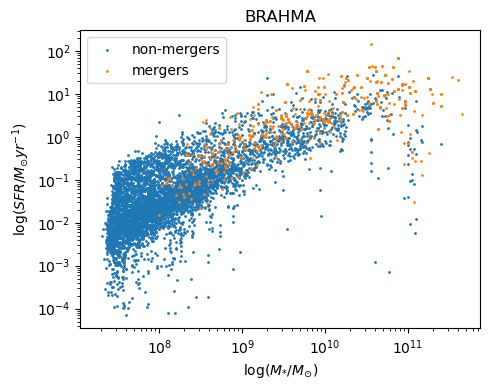

In [705]:
fig,axes = plt.subplots(1,1,figsize=[5,4],sharey=True)

#BRAHMA
axes.scatter(non_merging_pop['Mstar'][non_merging_pop['Mstar']>0],non_merging_pop['SFR'][non_merging_pop['Mstar']>0],s=1,label="non-mergers")
axes.scatter(merging_pop['Mstar'][merging_pop['Mstar']>0],merging_pop['SFR'][merging_pop['Mstar']>0],s=1,label="mergers")
axes.set_yscale('log',base=10)
axes.set_xscale('log',base=10)
axes.set_xlabel("$\log(M_{*}/M_{\odot})$")
axes.set_ylabel("$\log(SFR/M_{\odot} yr^{-1})$")
axes.set_title("BRAHMA")
axes.legend()
fig.tight_layout()

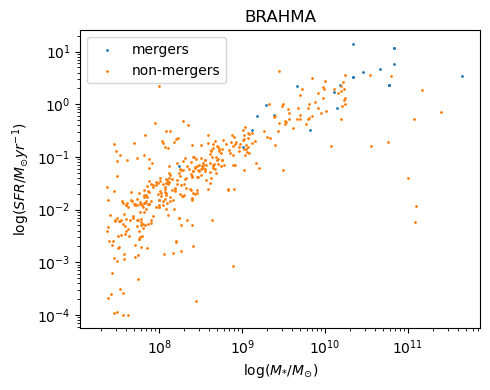

In [706]:
snap_z0 = 32

fig,axes = plt.subplots(1,1,figsize=[5,4],sharey=True)

axes.scatter(merging_pop['Mstar'][merging_pop['snap']==snap_z0],merging_pop['SFR'][merging_pop['snap']==snap_z0],s=1,label="mergers")
axes.scatter(non_merging_pop['Mstar'][non_merging_pop['snap']==snap_z0],non_merging_pop['SFR'][non_merging_pop['snap']==snap_z0],s=1,label="non-mergers")
axes.set_yscale('log',base=10)
axes.set_xscale('log',base=10)
axes.set_xlabel("$\log(M_{*}/M_{\odot})$")
axes.set_ylabel("$\log(SFR/M_{\odot} yr^{-1})$")
axes.set_title("BRAHMA")
axes.legend()
fig.tight_layout()

In [707]:
valid_non_merger_mask = non_merging_pop['Mstar'] > 0
print(np.sum(valid_non_merger_mask))

5873


In [653]:
merger_file_path = '/home/pranavsatheesh/host_galaxies/data/merger_files/'
merger_file = merger_file_path + 'brahma_merger_file_'+simName+'.npy'
bh_merger_properties = np.load(merger_file,allow_pickle=True).item()

true_merger_flag =  np.logical_and(np.array(bh_merger_properties['merger_type']) == 1,
                                           np.array(bh_merger_properties['remnant_SubhaloStellarMass']) > 0
)
print("The number of BH mergers in this run is %d"%(np.sum(true_merger_flag)))
N_mergers = np.sum(true_merger_flag)

brahma_merger_data = {}

for key in bh_merger_properties.keys():
    brahma_merger_data[key] = np.array(bh_merger_properties[key])[true_merger_flag]

brahma_merger_data = brahma_merger_data
z_bh_mergers = brahma_merger_data['remnant_redshift']

snap_list, z_list=arepo.get_snapshot_redshift_correspondence(basePath)
snap_list = snap_list
z_list = z_list

#find unique redshifts
unique_merger_z = np.unique(brahma_merger_data['remnant_redshift'])
unique_merger_snap = []

for z_i in unique_merger_z:
    idx = np.where(z_list == z_i)[0]
    unique_merger_snap.append(snap_list[idx[0]])

The number of BH mergers in this run is 2353


In [ ]:
merging_pop = initialize_population_dict(key='M')

In [ ]:
for i in tqdm(range(len(unique_merger_z)), desc="Processing unique merger redshifts"):
    merger_idxs = np.where(brahma_merger_data['remnant_redshift'] == unique_merger_z[i])[0]
    subhalos, o_redshift = arepo.get_subhalo_property(basePath, fields, unique_merger_z[i], postprocessed=1)
    
    subhalo_ids = np.arange(len(subhalos['SubhaloLenType'][:, 0]))
    Ngas = subhalos['SubhaloLenType'][:, 0]
    Ndm = subhalos['SubhaloLenType'][:, 1]
    Nstar = subhalos['SubhaloLenType'][:, 4]
    Nbh = subhalos['SubhaloLenType'][:, 5]
    subhalo_ids = np.arange(len(Ngas))
    particle_cut_mask = (Ngas >= minN_values[1]) & (Ndm >= minN_values[0]) & (Nstar >= minN_values[2]) & (Nbh >= minN_values[3])
    valid_subhalo_ids = subhalo_ids[particle_cut_mask]

    subhalo_ids_from_bh_merger = brahma_merger_data['remnant_SubhaloID'][merger_idxs]
    subhalo_ids_merging = np.intersect1d(valid_subhalo_ids, subhalo_ids_from_bh_merger)

    update_merger_details(merging_pop,subhalos,subhalo_ids_merging,unique_merger_z[i],unique_merger_snap[i],merger_idxs)

Processing unique merger redshifts: 100%|██████████| 23/23 [00:07<00:00,  3.24it/s]


In [ ]:
update_pop_units(merging_pop,key='M')

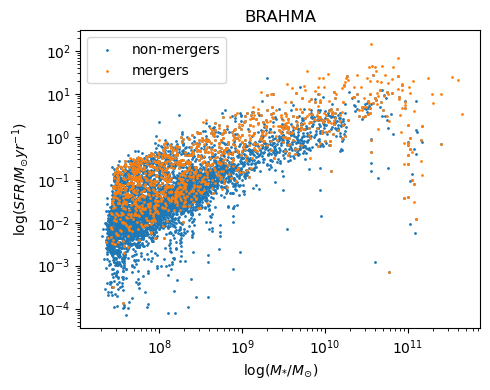

In [657]:
fig,axes = plt.subplots(1,1,figsize=[5,4],sharey=True)

#BRAHMA
axes.scatter(non_merging_pop['Mstar'][non_merging_pop['Mstar']>0],non_merging_pop['SFR'][non_merging_pop['Mstar']>0],s=1,label="non-mergers")
axes.scatter(merging_pop['Mstar'][merging_pop['Mstar']>0],merging_pop['SFR'][merging_pop['Mstar']>0],s=1,label="mergers")
axes.set_yscale('log',base=10)
axes.set_xscale('log',base=10)
axes.set_xlabel("$\log(M_{*}/M_{\odot})$")
axes.set_ylabel("$\log(SFR/M_{\odot} yr^{-1})$")
axes.set_title("BRAHMA")
axes.legend()
fig.tight_layout()

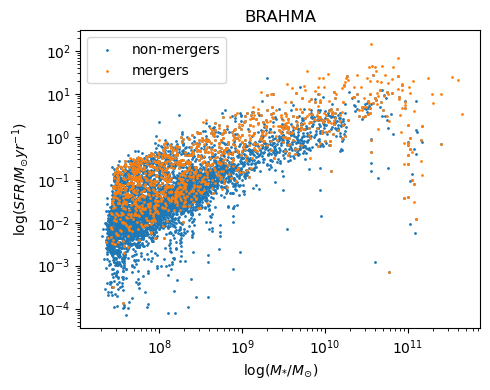

In [658]:
fig,axes = plt.subplots(1,1,figsize=[5,4],sharey=True)

#BRAHMA
axes.scatter(non_merging_pop['Mstar'][non_merging_pop['Mstar']>0],non_merging_pop['SFR'][non_merging_pop['Mstar']>0],s=1,label="non-mergers")
axes.scatter(merging_pop['Mstar'][merging_pop['Mstar']>0],merging_pop['SFR'][merging_pop['Mstar']>0],s=1,label="mergers")
axes.set_yscale('log',base=10)
axes.set_xscale('log',base=10)
axes.set_xlabel("$\log(M_{*}/M_{\odot})$")
axes.set_ylabel("$\log(SFR/M_{\odot} yr^{-1})$")
axes.set_title("BRAHMA")
axes.legend()
fig.tight_layout()

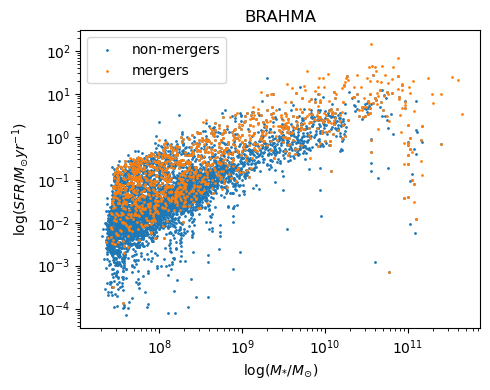

In [659]:
fig,axes = plt.subplots(1,1,figsize=[5,4],sharey=True)

#BRAHMA
axes.scatter(non_merging_pop['Mstar'][non_merging_pop['Mstar']>0],non_merging_pop['SFR'][non_merging_pop['Mstar']>0],s=1,label="non-mergers")
axes.scatter(merging_pop['Mstar'][merging_pop['Mstar']>0],merging_pop['SFR'][merging_pop['Mstar']>0],s=1,label="mergers")
axes.set_yscale('log',base=10)
axes.set_xscale('log',base=10)
axes.set_xlabel("$\log(M_{*}/M_{\odot})$")
axes.set_ylabel("$\log(SFR/M_{\odot} yr^{-1})$")
axes.set_title("BRAHMA")
axes.legend()
fig.tight_layout()

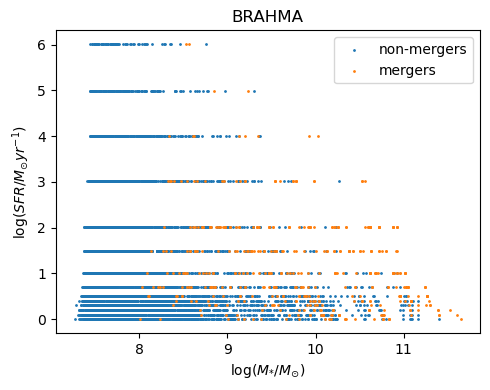

In [708]:
fig,axes = plt.subplots(1,1,figsize=[5,4],sharey=True)

axes.scatter(np.log10(non_merging_pop['Mstar'][non_merging_pop['Mstar']>0]),non_merging_pop['z'][non_merging_pop['Mstar']>0],s=1,label="non-mergers")
axes.scatter(np.log10(merging_pop['Mstar'][merging_pop['Mstar']>0]),merging_pop['z'][merging_pop['Mstar']>0],s=1,label="mergers")

axes.set_xlabel("$\log(M_{*}/M_{\odot})$")
axes.set_ylabel("$\log(SFR/M_{\odot} yr^{-1})$")
axes.set_title("BRAHMA")

#axes.set_ylim(5,10)
axes.legend()
fig.tight_layout()


In [709]:
valid_non_merger_mask = non_merging_pop['Mstar'] > 0
print(np.sum(valid_non_merger_mask))

5873


In [662]:
from scipy.spatial import cKDTree
from scipy.stats import ks_2samp

In [663]:
non_merging_z = non_merging_pop['z'][valid_non_merger_mask]
non_merging_Mstar = non_merging_pop['Mstar'][valid_non_merger_mask]
non_merging_SFR = non_merging_pop['SFR'][valid_non_merger_mask]
non_merging_Mdot = non_merging_pop['Mdot'][valid_non_merger_mask]

In [710]:
np.unique(merging_pop['snap'])

array([19., 20., 21., 22., 23., 24., 25., 26., 27., 28., 29., 30., 31.,
       32.])

In [711]:
si=17
idx_non_mergers_in_same_snap = np.where(non_merging_pop['snap']==si)
idx_mergers_in_same_snap = np.where(merging_pop['snap']==si)

while idx_non_mergers_in_same_snap[0].size ==0:
    si = si + 1
    idx_non_mergers_in_same_snap = np.where(non_merging_pop['snap']==si)
    idx_mergers_in_same_snap = np.where(merging_pop['snap']==si)

Mstar_mergers = merging_pop['Mstar'][idx_mergers_in_same_snap]
Mstar_non_mergers = non_merging_pop['Mstar'][idx_non_mergers_in_same_snap]

print(Mstar_mergers)
print(Mstar_non_mergers)

for Mi in Mstar_mergers:
    del_Mstar = np.abs(Mstar_non_mergers - Mi)
    closest_idx = np.argmin(del_Mstar)
    print(si,Mi, Mstar_non_mergers[closest_idx])
    print("SFR merger:", merging_pop['SFR'][idx_mergers_in_same_snap][np.where(Mstar_mergers==Mi)[0][0]], "SFR non-merger:", non_merging_pop['SFR'][idx_non_mergers_in_same_snap][closest_idx])

[3.37578258e+08 3.64911111e+08]
[5.68723581e+08 9.92590079e+07 5.01594473e+07 1.81747208e+08
 3.32167007e+07 7.87523192e+07 1.18436035e+08 5.55457715e+07
 2.28130209e+08 1.95881992e+08 3.08782675e+07 2.91887416e+08
 1.07593533e+08 2.23941981e+08 6.85394339e+07 3.83462717e+07
 4.15538327e+07 5.81287646e+07 3.19753190e+07 7.28934048e+07
 5.48874155e+07 1.15224863e+08 1.37693065e+08 1.90184460e+08
 8.05615897e+07 5.35438957e+07 1.13430200e+08 3.87451236e+07
 1.21003189e+08 3.12155985e+07 2.88937636e+07 4.42932739e+07
 3.78744140e+07 3.86006867e+07 4.80066115e+07 4.65120388e+07
 6.52554937e+07 5.56529163e+07 3.45498221e+07 5.57719003e+07
 9.54289215e+07 8.53153305e+07 4.11001208e+07 5.02988156e+07
 8.58519586e+07 7.09270088e+07 2.89680281e+07 3.89191912e+07
 5.73425838e+07 4.73999692e+07 3.37093519e+07 4.96352121e+07
 4.32868719e+07 5.23035524e+07 5.44064969e+07 4.22095926e+07
 4.78243908e+07 5.15069147e+07 3.71989541e+07 3.37387180e+07
 5.45834530e+07 4.94134092e+07 3.09279972e+07 3.72338

In [712]:
merging_points = np.column_stack((merging_pop['z'],np.log10(merging_pop['Mstar'])))
non_merging_points = np.column_stack((non_merging_z,np.log10(non_merging_Mstar)))
tree = cKDTree(non_merging_points)
used = np.zeros(len(non_merging_points), dtype=bool)

control_indices = []

while True:
    closest_indices = np.full(len(merging_points), -1)
    
    tolerances = []
    for i in tqdm(range(len(merging_points)), desc="Processing merging points", ncols=100):
        #find the closest neibhour 
        dist, min_idx = tree.query(merging_points[i])
        if(used[min_idx]):
            dists,idxs = tree.query(merging_points[i],k=len(non_merging_points))
            min_idx = idxs[np.where(~used[idxs])[0][0]] 

        #check for tolerance:
        del_z = np.abs(merging_points[i][0]-non_merging_points[min_idx][0])
        dex_Mstar = np.abs(np.log10(merging_points[i][1]/non_merging_points[min_idx][1]))

        z_tolerance = 0.05
        Mstar_dex_tolerance = 0.1

        while True:
            if(del_z<z_tolerance and dex_Mstar<Mstar_dex_tolerance):
                used[min_idx] = True
                closest_indices[i] = min_idx
                tolerances.append((z_tolerance, Mstar_dex_tolerance))
                break
            else:
                closest_indices[i] = -1
                break

                

    control_indices.append(closest_indices)
        #D_mstar, p_Mstar = ks_2samp(pop['non_merging_population']['Mstar'][np.sort(closest_indices)],pop['merging_population']['Mstar'])
        #D_z, p_z = ks_2samp(pop['non_merging_population']['z'][np.sort(closest_indices)],pop['merging_population']['z'])
        
        #print(p_z,p_Mstar,np.shape(control_indices)[0])
        #print(z_tolerance,Mstar_dex_tolerance)

    if np.shape(control_indices)[0]>=1:
        break

Processing merging points:   0%|                                            | 0/460 [00:00<?, ?it/s]

Processing merging points: 100%|████████████████████████████████| 460/460 [00:00<00:00, 3264.60it/s]


In [713]:
print("Number of cases where a close enough match is not found within the acceptable tolerance:",np.sum(control_indices[0]==-1))

Number of cases where a close enough match is not found within the acceptable tolerance: 116


In [714]:
mergers_with_MBH_not_zero = merging_pop['MBH'] != 0 
mergers_with_Mstar_not_zero = merging_pop['Mstar'] !=0
mergers_with_controls_found = control_indices[0]!=-1
valid_control_mask = mergers_with_MBH_not_zero & mergers_with_Mstar_not_zero & mergers_with_controls_found

print("number of processable mergers with valid controls:")
print(len(control_indices[0][valid_control_mask]))

number of processable mergers with valid controls:
343


Text(0.5, 0.98, 'BRAHMA output_ratio10_SFMFGM5_seed5.00_bFOF_LW10_DFD_3')

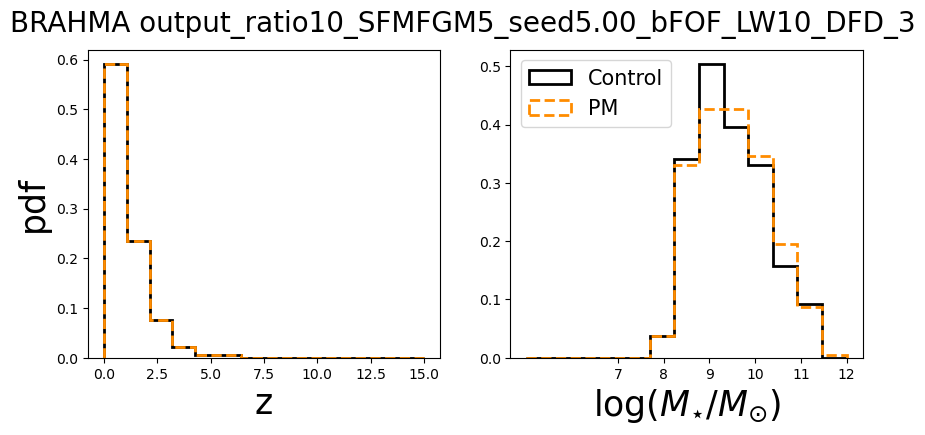

In [716]:
Mstar_binsize = 0.5
Mstar_min = 5
Mstar_max = 12
Nbins_Ms = int((Mstar_max - Mstar_min) / Mstar_binsize)
Mstar_bins = np.linspace(Mstar_min, Mstar_max, Nbins_Ms)

z_binsize = 1
z_min = 0
z_max = 15
Nbins_z = int((z_max - z_min) / z_binsize)
z_bins = np.linspace(z_min, z_max, Nbins_z )

fig,ax = plt.subplots(1,2,figsize=(10,4))

ax[0].hist(non_merging_z[control_indices[0][valid_control_mask]], bins=z_bins, color="black", histtype="step",linewidth=2,density=True)
ax[0].hist(merging_pop['z'][valid_control_mask], bins=z_bins, histtype="step",color="Darkorange",linestyle="--",linewidth=2,density=True)
ax[0].set_xlabel("z",fontsize=25)
ax[0].set_ylabel("pdf",fontsize=25)
#ax[0].set_xticks([0,1,2,3,4,5])


ax[1].hist(np.log10(non_merging_Mstar[control_indices[0][valid_control_mask]]), bins=Mstar_bins,histtype="step",color="black",label="Control",linewidth=2,density=True)
ax[1].hist(np.log10(merging_pop['Mstar'][valid_control_mask]),bins=Mstar_bins,histtype="step",label="PM",color="Darkorange",linestyle="--",linewidth=2,density=True)
ax[1].set_xticks([7,8,9,10,11,12])
ax[1].legend(fontsize=15)
ax[1].set_xlabel("$\log(M_{\star}/M_{\odot})$",fontsize=25)

fig.suptitle("BRAHMA "+simName,fontsize=20)

In [717]:
z_merging_pop = merging_pop['z'][:][valid_control_mask]
z_control_pop = non_merging_z[control_indices[0][valid_control_mask]]

Mstar_merging_pop = merging_pop['Mstar'][:][valid_control_mask]
Mstar_control_pop = non_merging_Mstar[control_indices[0][valid_control_mask]]

MBH_merging_pop = merging_pop['MBH'][:][valid_control_mask]
MBH_control_pop = non_merging_pop['MBH'][control_indices[0][valid_control_mask]]

SFR_merging_pop = merging_pop['SFR'][:][valid_control_mask]
SFR_control_pop = non_merging_pop['SFR'][control_indices[0][valid_control_mask]]

sSFR_merging_pop = SFR_merging_pop/Mstar_merging_pop
sSFR_control_pop = SFR_control_pop/Mstar_control_pop

Mgas_merging_pop = merging_pop['Mgas'][:][valid_control_mask]
Mgas_control_pop = non_merging_pop['Mgas'][:][non_merging_pop['Mstar']>0][control_indices[0][valid_control_mask]]

# fgas_merging_pop = Mgas_merging_pop/(Mgas_merging_pop+Mstar_merging_pop)
# fgas_control_pop = Mgas_control_pop/(Mgas_control_pop+Mstar_control_pop)

Mdot_merging_pop = merging_pop['Mdot'][:][valid_control_mask]
Mdot_control_pop = non_merging_Mdot[control_indices[0][valid_control_mask]]

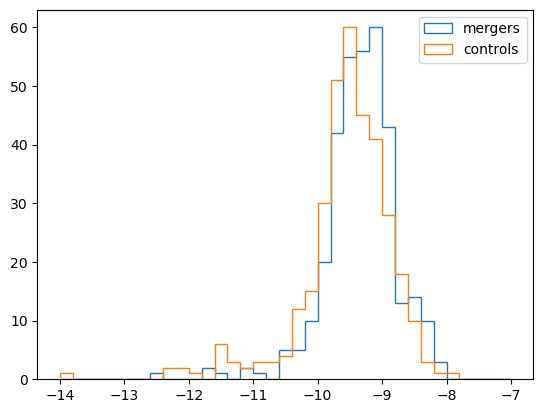

In [718]:
binsize = 0.2
bin_min = -14
bin_max = -7
bins= np.arange(bin_min,bin_max+binsize,binsize)

plt.hist(np.log10(sSFR_merging_pop[sSFR_merging_pop>0]),bins=bins,histtype="step",label="mergers")
plt.hist(np.log10(sSFR_control_pop[sSFR_control_pop>0]),bins=bins,histtype="step",label="controls")
#plt.xscale("log",base=10)
plt.legend()

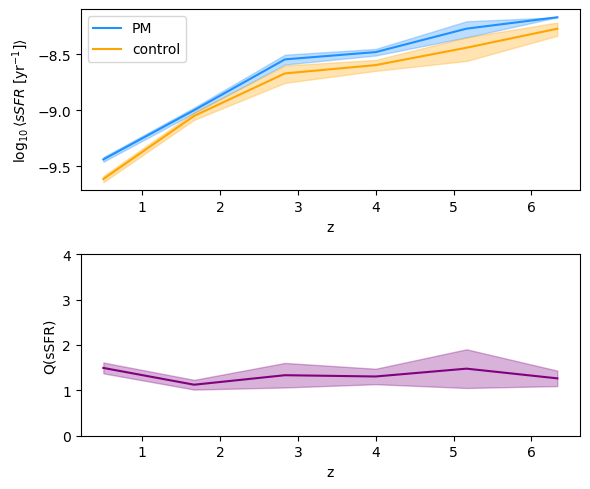

In [721]:
z_min = 0
z_max = 7
z_binsize = 1

Nbins_z = int((z_max - z_min) / z_binsize)
z_bins = np.linspace(z_min, z_max, Nbins_z)

avg_sSFR_control = []
std_sSFR_control = []

avg_sSFR_merger = []
std_sSFR_merger = []

# Loop through redshift bins
for i in range(len(z_bins) - 1):
    # Create masks for merging and control populations within each redshift bin
    merger_z_mask = (z_merging_pop > z_bins[i]) & (z_merging_pop < z_bins[i + 1])
    control_z_mask = (z_control_pop > z_bins[i]) & (z_control_pop < z_bins[i + 1])

    sSFR_merging_pop_filtered = sSFR_merging_pop[merger_z_mask]
    sSFR_control_pop_filtered = sSFR_control_pop[control_z_mask]

    avg_sSFR_merger.append(np.mean(sSFR_merging_pop_filtered))
    std_sSFR_merger.append(np.std(sSFR_merging_pop_filtered) / np.sqrt(len(sSFR_merging_pop_filtered)))

    avg_sSFR_control.append(np.mean(sSFR_control_pop_filtered))
    std_sSFR_control.append(np.std(sSFR_control_pop_filtered) / np.sqrt(len(sSFR_control_pop_filtered)))

avg_sSFR_merger = np.array(avg_sSFR_merger)
std_sSFR_merger = np.array(std_sSFR_merger)

avg_sSFR_control = np.array(avg_sSFR_control)
std_sSFR_control = np.array(std_sSFR_control)

Q_sSFR = avg_sSFR_merger / avg_sSFR_control
Q_sSFR_SE = Q_sSFR * np.sqrt((std_sSFR_merger / avg_sSFR_merger) ** 2 + (std_sSFR_control / avg_sSFR_control) ** 2)

# Plot the results
fig, ax = plt.subplots(2, 1, figsize=(6, 5))
ax[0].plot(z_bins[:-1] + z_binsize / 2, np.log10(avg_sSFR_merger[avg_sSFR_merger > 0]), label='PM', color="dodgerblue")
ax[0].fill_between(z_bins[:-1] + z_binsize / 2, np.log10(avg_sSFR_merger - std_sSFR_merger), np.log10(avg_sSFR_merger + std_sSFR_merger), alpha=0.3, color='dodgerblue')
ax[0].plot(z_bins[:-1] + z_binsize / 2, np.log10(avg_sSFR_control[avg_sSFR_control > 0]), label='control', color='orange')
ax[0].fill_between(z_bins[:-1] + z_binsize / 2, np.log10(avg_sSFR_control - std_sSFR_control), np.log10(avg_sSFR_control + std_sSFR_control), alpha=0.3, color='orange')
ax[0].legend()
ax[0].set_xlabel('z')
ax[0].set_ylabel(r'$\log_{10}\langle sSFR \; [\mathrm{yr}^{-1}]\rangle$')

ax[1].plot(z_bins[:-1] + z_binsize / 2, Q_sSFR, color='purple')
ax[1].fill_between(z_bins[:-1] + z_binsize / 2, Q_sSFR - Q_sSFR_SE, Q_sSFR + Q_sSFR_SE, alpha=0.3, color='purple')
ax[1].set_xlabel('z')
ax[1].set_ylabel('Q(sSFR)')
ax[1].set_ylim(0, 4)

# Final layout adjustments
fig.tight_layout()

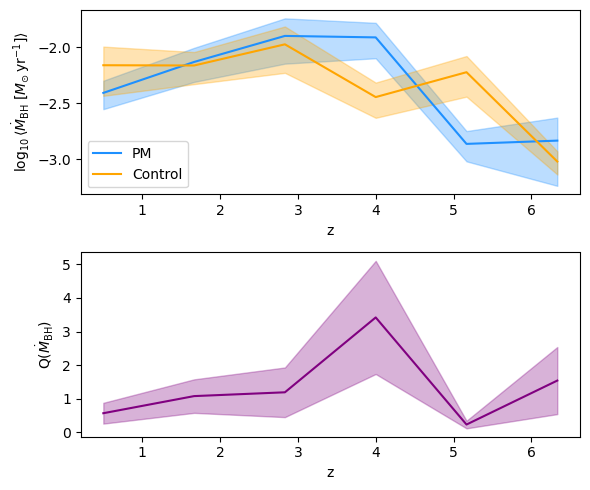

In [724]:
z_min = 0
z_max=7
z_binsize = 1
Nbins_z = int((z_max - z_min) / z_binsize)
z_bins = np.linspace(z_min, z_max, Nbins_z)

avg_Mdot_control = []
std_Mdot_control = []

avg_Mdot_merger = []
std_Mdot_merger = []

# Loop through redshift bins
for i in range(len(z_bins) - 1):
    # Create masks for merging and control populations within each redshift bin
    merger_z_mask = (z_merging_pop > z_bins[i]) & (z_merging_pop < z_bins[i+1])
    control_z_mask = (z_control_pop > z_bins[i]) & (z_control_pop < z_bins[i+1])

    # Get the Mdot for each population
    Mdot_merging_pop_filtered = Mdot_merging_pop[merger_z_mask]
    Mdot_control_pop_filtered = Mdot_control_pop[control_z_mask]

    avg_Mdot_merger.append(np.mean(Mdot_merging_pop_filtered))
    std_Mdot_merger.append(np.std(Mdot_merging_pop_filtered) / np.sqrt(len(Mdot_merging_pop_filtered)))

    avg_Mdot_control.append(np.mean(Mdot_control_pop_filtered))
    std_Mdot_control.append(np.std(Mdot_control_pop_filtered) / np.sqrt(len(Mdot_control_pop_filtered)))

avg_Mdot_merger = np.array(avg_Mdot_merger)
std_Mdot_merger = np.array(std_Mdot_merger)

avg_Mdot_control = np.array(avg_Mdot_control)
std_Mdot_control = np.array(std_Mdot_control)

Q_Mdot = avg_Mdot_merger / avg_Mdot_control
Q_Mdot_SE = Q_Mdot * np.sqrt((std_Mdot_merger / avg_Mdot_merger) ** 2 + (std_Mdot_control / avg_Mdot_control) ** 2)

# Plot the results
fig, ax = plt.subplots(2, 1, figsize=(6, 5))
ax[0].plot(z_bins[:-1] + z_binsize / 2, np.log10(avg_Mdot_merger[avg_Mdot_merger > 0]), label='PM', color='dodgerblue')
ax[0].fill_between(z_bins[:-1] + z_binsize / 2, np.log10(avg_Mdot_merger - std_Mdot_merger), np.log10(avg_Mdot_merger + std_Mdot_merger), alpha=0.3, color='dodgerblue')

ax[0].plot(z_bins[:-1] + z_binsize / 2, np.log10(avg_Mdot_control[avg_Mdot_control > 0]), label='Control', color="orange")
ax[0].fill_between(z_bins[:-1] + z_binsize / 2, np.log10(avg_Mdot_control - std_Mdot_control), np.log10(avg_Mdot_control + std_Mdot_control), alpha=0.3, color='orange')

ax[0].legend()
ax[0].set_xlabel('z')
ax[0].set_ylabel(r'$\log_{10}\langle \dot{M}_{\mathrm{BH}} \; [M_{\odot} \, \mathrm{yr}^{-1}]\rangle$')

ax[1].plot(z_bins[:-1] + z_binsize / 2, Q_Mdot, color='purple')
ax[1].fill_between(z_bins[:-1] + z_binsize / 2, Q_Mdot - Q_Mdot_SE, Q_Mdot + Q_Mdot_SE, alpha=0.3, color='purple')
ax[1].set_xlabel('z')
ax[1].set_ylabel('Q($\dot{M}_{\mathrm{BH}}$)')
#ax[1].set_ylim(0, 5)

# Final layout adjustments
fig.tight_layout()